In [29]:
import pandas_datareader.data as web
from pandas_datareader.data import Options
import itertools 
import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file
from bokeh.io import push_notebook, output_notebook
# select a palette
from bokeh.palettes import Dark2_5 as palette
import warnings
warnings.filterwarnings('ignore')


matplotlib.style.use('ggplot')
%matplotlib inline

output_notebook()

Loading BokehJS ...

In [30]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [31]:
start = datetime.datetime(2008, 1, 1)
end = datetime.datetime(2017, 10, 10)

# Functions

In [32]:
def load_csv(fname, skiprows=1, start=start, end=end):
    df = pd.read_csv(fname,skiprows=skiprows)
    df.Date=pd.to_datetime(df.Date)
    df=df.set_index('Date')
    df=df.loc[start:end]
    return df

def load_symbol(fname, start=start, end=end, source='yahoo'):
    start=str(start)[:10]
    end=str(end)[:10]
    df = web.DataReader(fname, source, start,end)
    return df

def plot_bokeh1(stocks, legends, column='Close'):
    p1 = figure(x_axis_type="datetime", title=column, plot_width=800)
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = column
    
    colors = itertools.cycle(palette)  
    
    for y, color,z in zip(stocks, colors, legends):
        p1.line(y.index, y[column], color=color,legend=z)
    
    p1.legend.location = "top_left"

    #output_file("stocks.html", title="stocks.py example")

    show(p1)  # open a browser

def plot_bokeh2(stocks, legends, stock, legend):
    p1 = figure(x_axis_type="datetime", title="Stock Closing Prices")
    p1.grid.grid_line_alpha=0.3
    p1.xaxis.axis_label = 'Date'
    p1.yaxis.axis_label = ' Close Price'
    
    colors = itertools.cycle(palette)  
    
    for y, color,z in zip(stocks, colors, legends):
        p1.line(y.index, y['Close'], color=color,legend=z)
    
    p1.legend.location = "top_left"

    aapl = np.array(stock['Close'])
    aapl_dates = np.array(stock.index, dtype=np.datetime64)

    window_size = 50
    window = np.ones(window_size)/float(window_size)
    aapl_avg = np.convolve(aapl, window, 'same')

    p2 = figure(x_axis_type="datetime", title="50 days Average")
    p2.grid.grid_line_alpha = 0
    p2.xaxis.axis_label = 'Date'
    p2.yaxis.axis_label = 'Price'
    p2.ygrid.band_fill_color = "olive"
    p2.ygrid.band_fill_alpha = 0.1

    p2.circle(aapl_dates, aapl, size=4, legend='close',
              color='darkgrey', alpha=0.2)

    p2.line(aapl_dates, aapl_avg, legend='avg', color='navy')
    p2.legend.location = "top_left"

    #output_file("stocks.html", title="stocks.py example")

    show(gridplot([[p1,p2]], plot_width=400, plot_height=400))  # open a browser

# Loading Data

In [33]:
vix=load_csv('vixcurrent.csv',start=start, end=end)
vvix=load_csv('vvixtimeseries.csv',start=start, end=end)

vvix.columns=['Close']
vix.columns=['Open', 'High', 'Low', 'Close']

spy=pd.read_csv('spy.csv')
spy.Date=pd.to_datetime(spy.Date)
spy=spy.set_index('Date')

spy_change=spy.pct_change()
vix_change=vix.pct_change()

spy_abschange=abs(spy_change)
vix_abschange=abs(vix_change)

spy20mean=pd.rolling_mean(spy, window=20)
spy50mean=pd.rolling_mean(spy, window=50)
spy200mean=pd.rolling_mean(spy, window=200)



# VOLATILITY DISPERSION METHODOLOGY

In [34]:
vix_20std=pd.rolling_std(vix, window=20).ix[19:]

stocks=[vix_20std,vix]
legends=['20-day standard deviation','VIX']

plot_bokeh1(stocks, legends)

In [35]:
vix_20max_return=pd.rolling_max(vix,20).shift(-19)/vix-1.0
vix_20max_return=vix_20max_return[:-19]

In [36]:
df=pd.merge(vix_20std.reset_index(),vix_20max_return.reset_index(), on='Date')

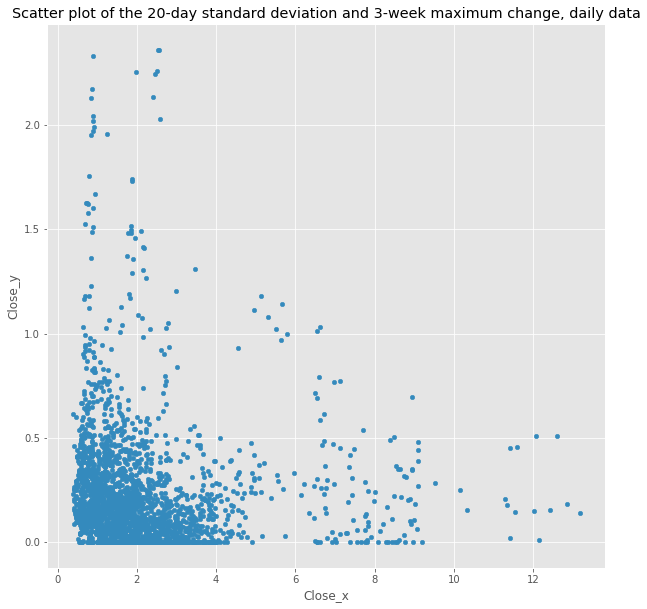

In [37]:
df.plot(kind='scatter',x='Close_x',y='Close_y',\
        title='Scatter plot of the 20-day standard deviation and 3-week maximum change, daily data',figsize=(10,10))
plt.show()

In [38]:
vix_20std_10min=pd.rolling_min(vix_20std,10)
vix_20std_10min=vix_20std_10min.shift(1)
vix_20std_10min=vix_20std_10min.ix[10:]

In [39]:
df_signal=pd.merge(vix_20std_10min.reset_index(),vix_20std.reset_index(),on='Date')

In [40]:
signal_date=df_signal[(df_signal.Close_x > 0.86) & (df_signal.Close_y < 0.86)].Date.tolist()

In [41]:
signal_vix=vix.ix[signal_date]

In [42]:
vix_5max_change=pd.rolling_max(vix,5).shift(-4)/vix-1.0

In [43]:
vix_5max_change=vix_5max_change.shift(4)

In [44]:
signal_30=vix_5max_change[vix_5max_change.Close > 0.30].index.tolist()
signal_sell=vix.ix[signal_30]

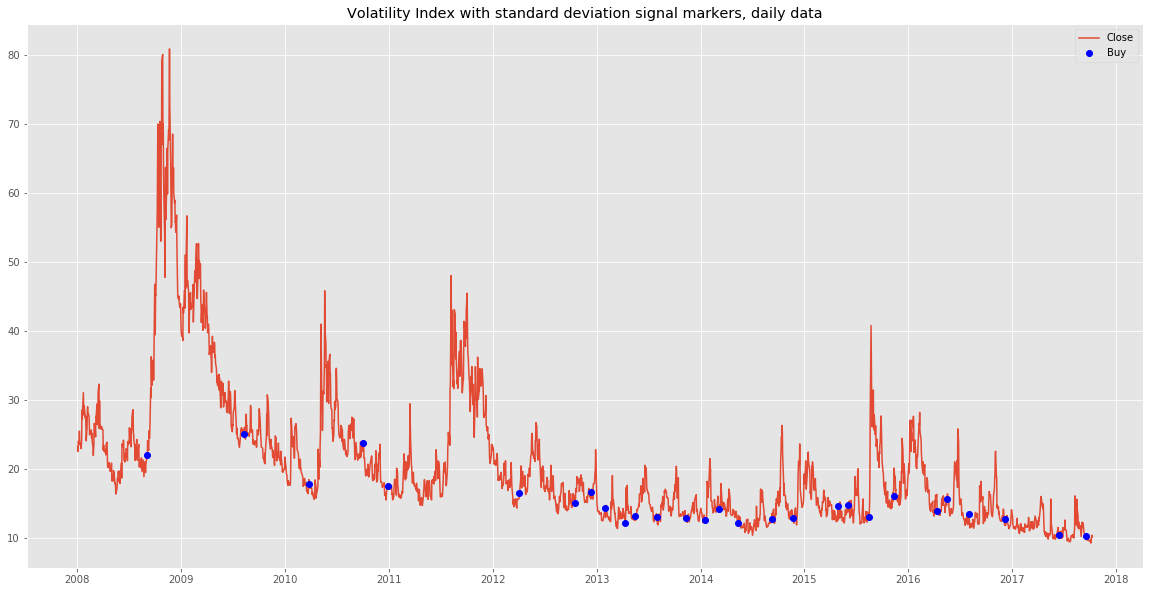

In [45]:
plt.figure(figsize=[20,10])
plt.title('Volatility Index with standard deviation signal markers, daily data')
#plt.plot(spy['Close'])
#plt.plot(spy['Volume']/10000000.0)
plt.plot(vix['Close'])
plt.plot(signal_vix['Close'],'bo',label='Buy')
#plt.plot(signal_sell['Close'],'go',label='Sell')
plt.legend(loc=1)
plt.show()
#plt.plot(spy['Volume']/10000000.0)

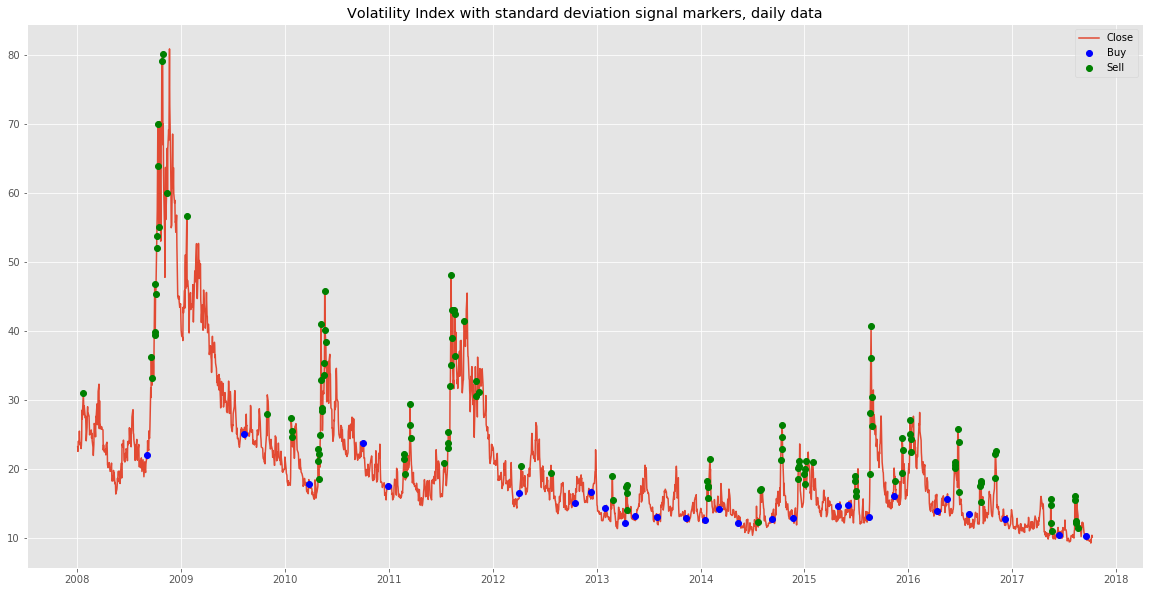

In [46]:
plt.figure(figsize=[20,10])
plt.title('Volatility Index with standard deviation signal markers, daily data')
#plt.plot(spy['Close'])
#plt.plot(spy['Volume']/10000000.0)
plt.plot(vix['Close'])
plt.plot(signal_vix['Close'],'bo',label='Buy')
plt.plot(signal_sell['Close'],'go',label='Sell')
plt.legend(loc=1)
plt.show()
#plt.plot(spy['Volume']/10000000.0)

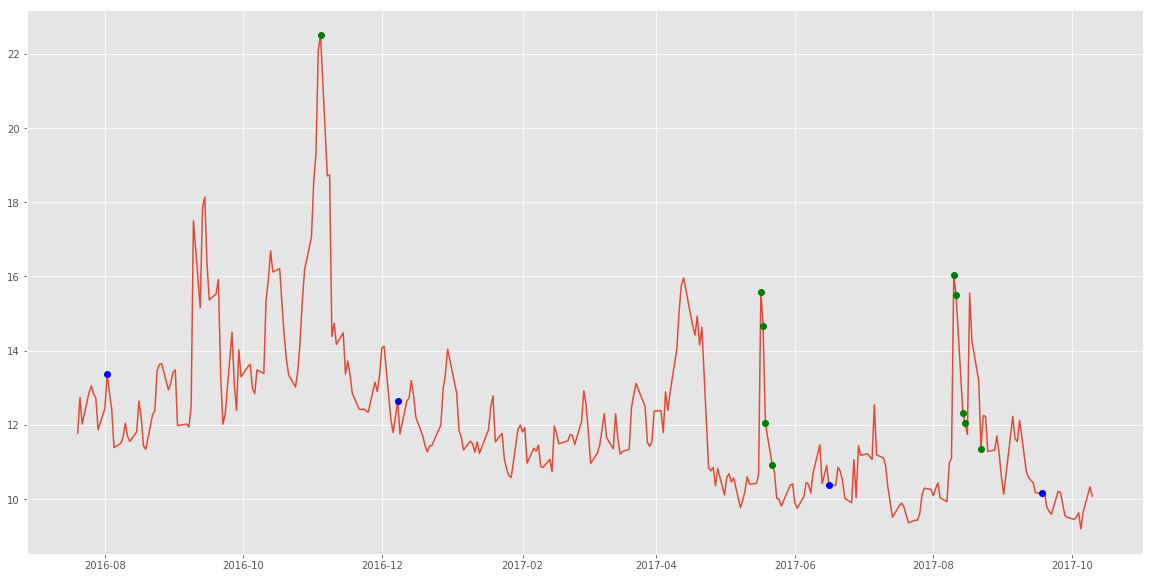

In [47]:
plt.figure(figsize=[20,10])
#plt.plot(spy['Close'])
#plt.plot(spy['Volume']/10000000.0)
plt.plot(vix.ix[-310:]['Close'])
plt.plot(signal_vix.ix[-4:]['Close'],'bo')
plt.plot(signal_sell.ix[-10:]['Close'],'go')
plt.show()
#plt.plot(spy['Volume']/10000000.0)

# Using VVIX

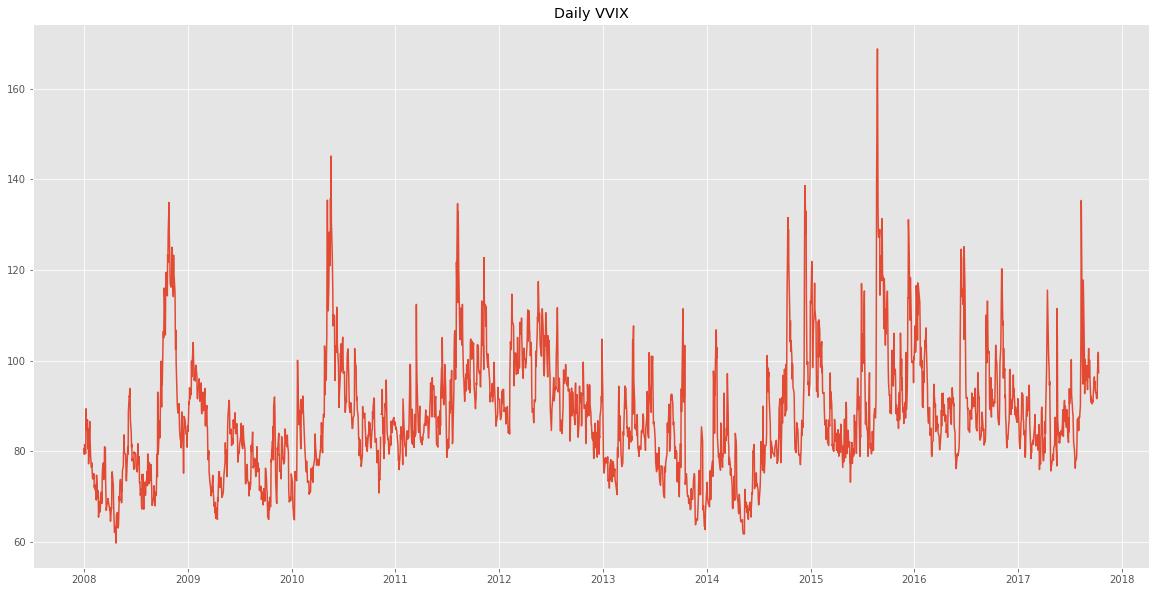

In [48]:
plt.figure(figsize=[20,10])
plt.title('Daily VVIX')
plt.plot(vvix['Close'])
plt.show()
#plt.plot(signal_vix.ix[-4:]['Close'],'bo')
#plt.plot(signal_sell.ix[-10:]['Close'],'go')
#plt.plot(spy['Volume']/10000000.0)

In [49]:
vvix_20std=pd.rolling_std(vvix, window=20).ix[19:]

print(vvix_20std.quantile(.15))

Close    3.184134
Name: 0.15, dtype: float64


In [50]:
stocks=[vvix_20std,vvix]
legends=['20-day standard deviation for VVIX','VVIX']

plot_bokeh1(stocks, legends)

In [51]:
vix_20std.quantile(.15)

Open     0.820536
High     0.958822
Low      0.692947
Close    0.841777
Name: 0.15, dtype: float64

In [52]:
vvix_20std.quantile(.15)

Close    3.184134
Name: 0.15, dtype: float64

In [53]:
vvix_20max_return=pd.rolling_max(vvix,20).shift(-19)/vix-1.0
vvix_20max_return=vvix_20max_return[:-19]

vvix_20std_10min=pd.rolling_min(vvix_20std,10)
vvix_20std_10min=vvix_20std_10min.shift(1)
vvix_20std_10min=vvix_20std_10min.ix[10:]

df_signal_vvix=pd.merge(vvix_20std_10min.reset_index(),vvix_20std.reset_index(),on='Date')


In [54]:
signal_date_vvix=df_signal_vvix[(df_signal_vvix.Close_x > 3.16) & (df_signal_vvix.Close_y < 3.16)].Date.tolist()
signal_vvix=vix.ix[signal_date_vvix]

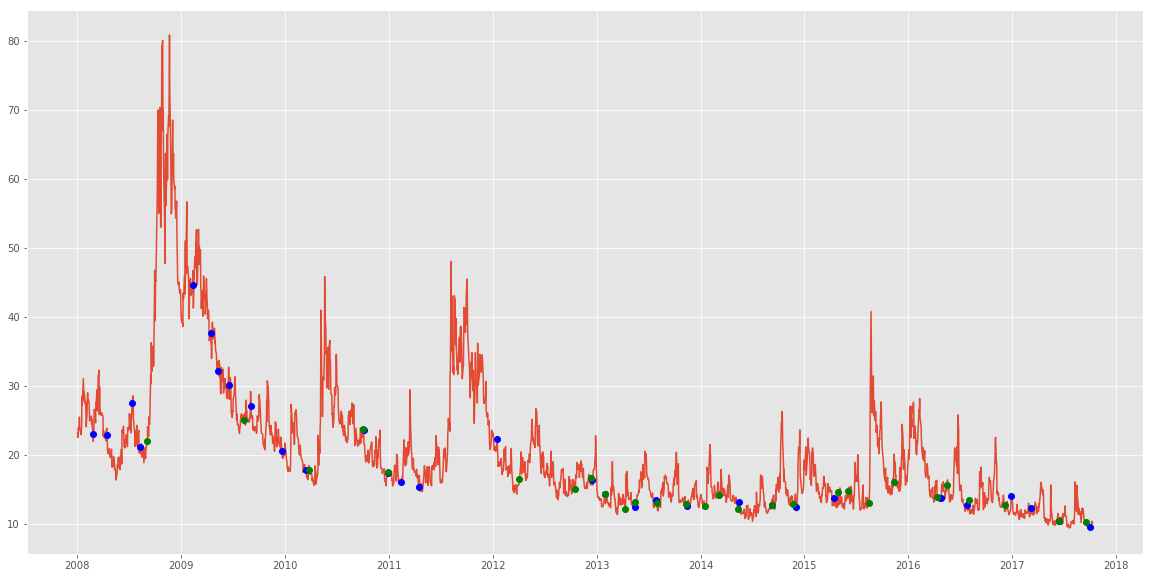

In [55]:
plt.figure(figsize=[20,10])
#plt.plot(spy['Close'])
#plt.plot(spy['Volume']/10000000.0)
plt.plot(vix['Close'])
plt.plot(signal_vvix['Close'],'bo')
plt.plot(signal_vix['Close'],'go')
#plt.plot(signal_sell['Close'],'go')
#plt.plot(spy['Volume']/10000000.0)
plt.show()

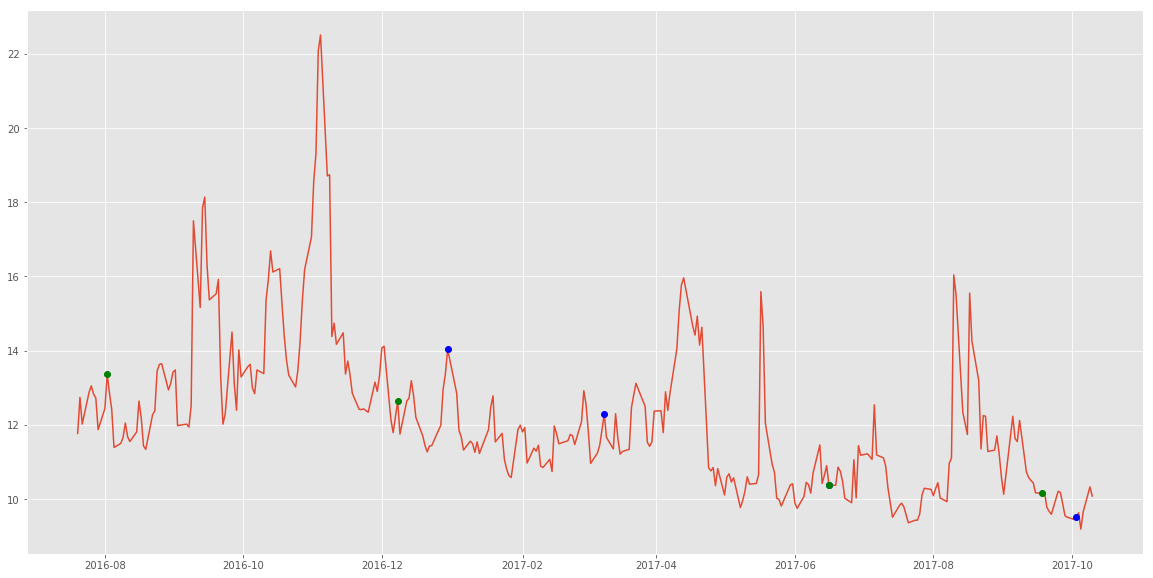

In [56]:
plt.figure(figsize=[20,10])
#plt.plot(spy['Close'])
#plt.plot(spy['Volume']/10000000.0)
plt.plot(vix.ix[-310:]['Close'])

plt.plot(signal_vvix.ix[-4:]['Close'],'bo')
plt.plot(signal_vix.ix[-4:]['Close'],'go')
plt.show()
#plt.plot(signal_sell.ix[-10:]['Close'],'go')
#plt.plot(spy['Volume']/10000000.0)

# Conclusion